# **Clustering & PCA Assignment**
Help NGO To Identify The Nations In Dire Need of The Aid

### **About Dataset**
After the current funding programs, International Humanitarian NGO has raised around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision have mostly related to the countries in dire need of Aid. Our job is as Data analyst is to classify the countries using the socio-economic and health factors that determine the overall development of nations. After this analysis, we need to suggest countries that the CEO needs to focus on and give the highest priority.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from factor_analyzer.factor_analyzer import calculate_kmo

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from scipy.stats import chi2



import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Data contains

1. Name of the country,
2. Death of children under five years of age per 1000 live births,
3. Exports of goods and services; Exports of goods and services given as %age of the Total GDP;
4. Imports of goods and services, Given as %age of the Total GDP;
5. Net income per person;
6. The measurement of the annual growth rate of the Total GDP;
7. The average number of years a newborn child would live if the current mortality patterns are to remain the same;
8. The number of children born to each woman if the current age-fertility rates remain the same.

## Exploratory analysis of the variables

In [3]:
num_var = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
char_var = ['country']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


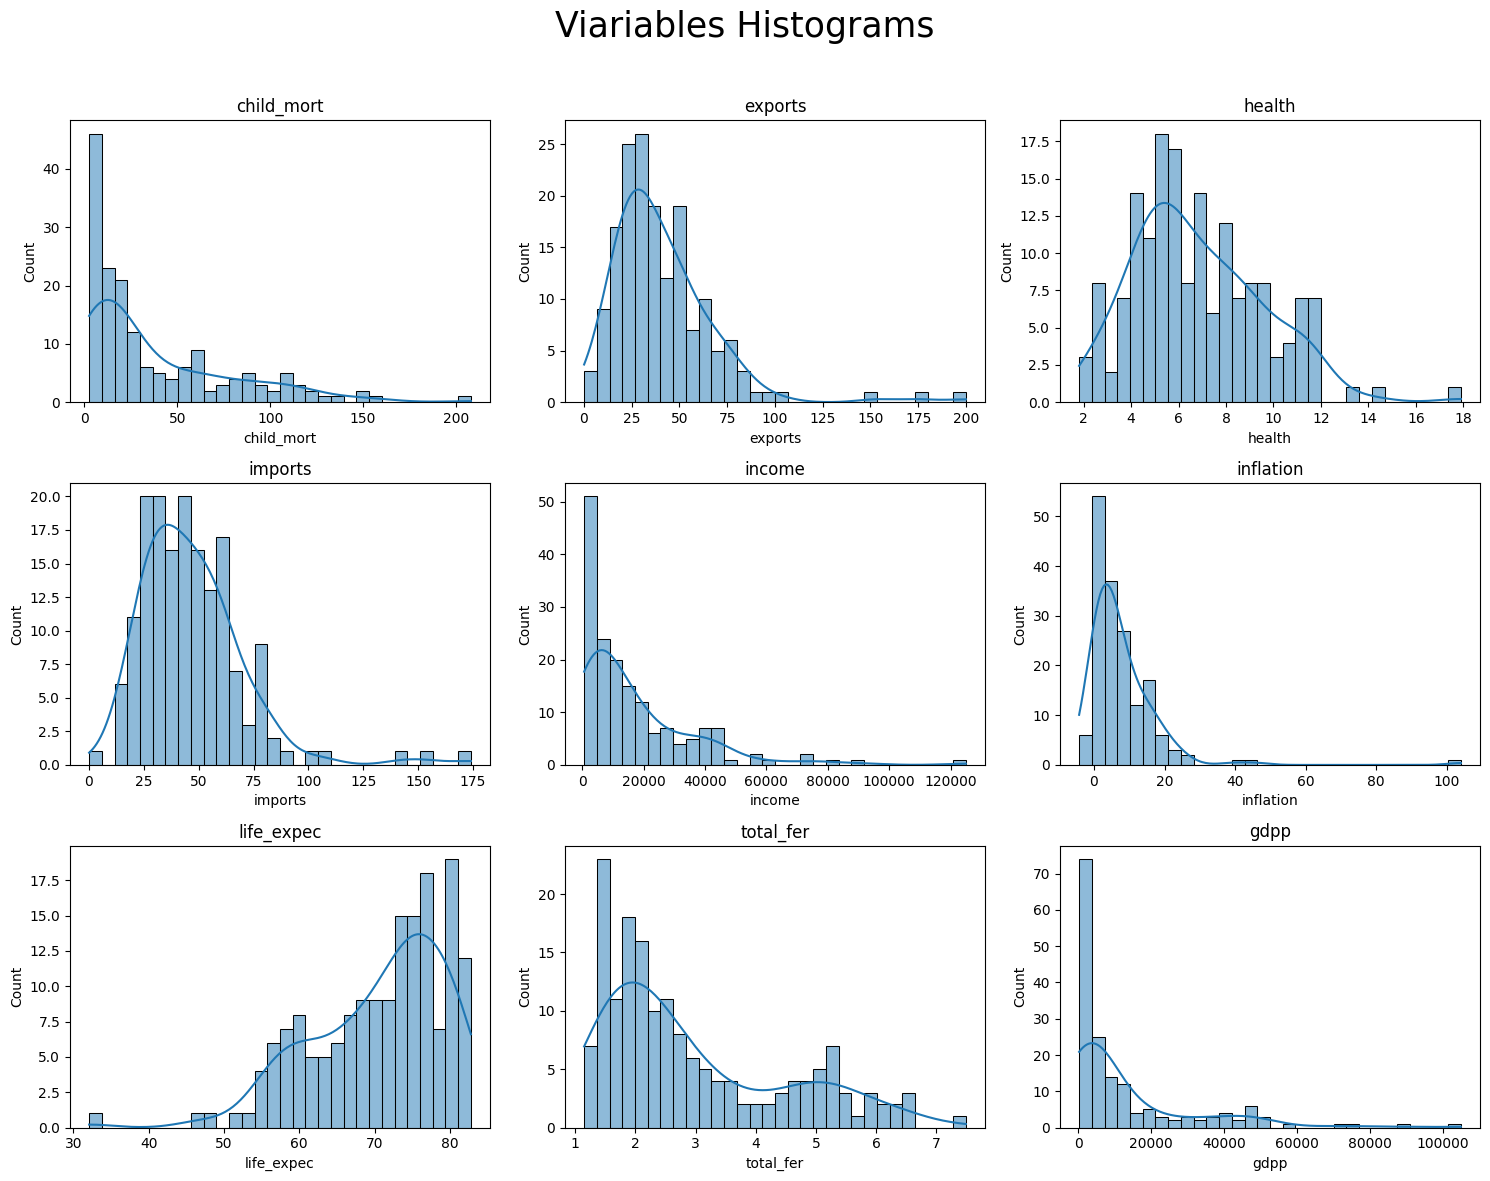

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  
axes = axes.flatten()  

for i, var in enumerate(num_var):
    sns.histplot(df[var], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(var)
plt.suptitle("Viariables Histograms", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

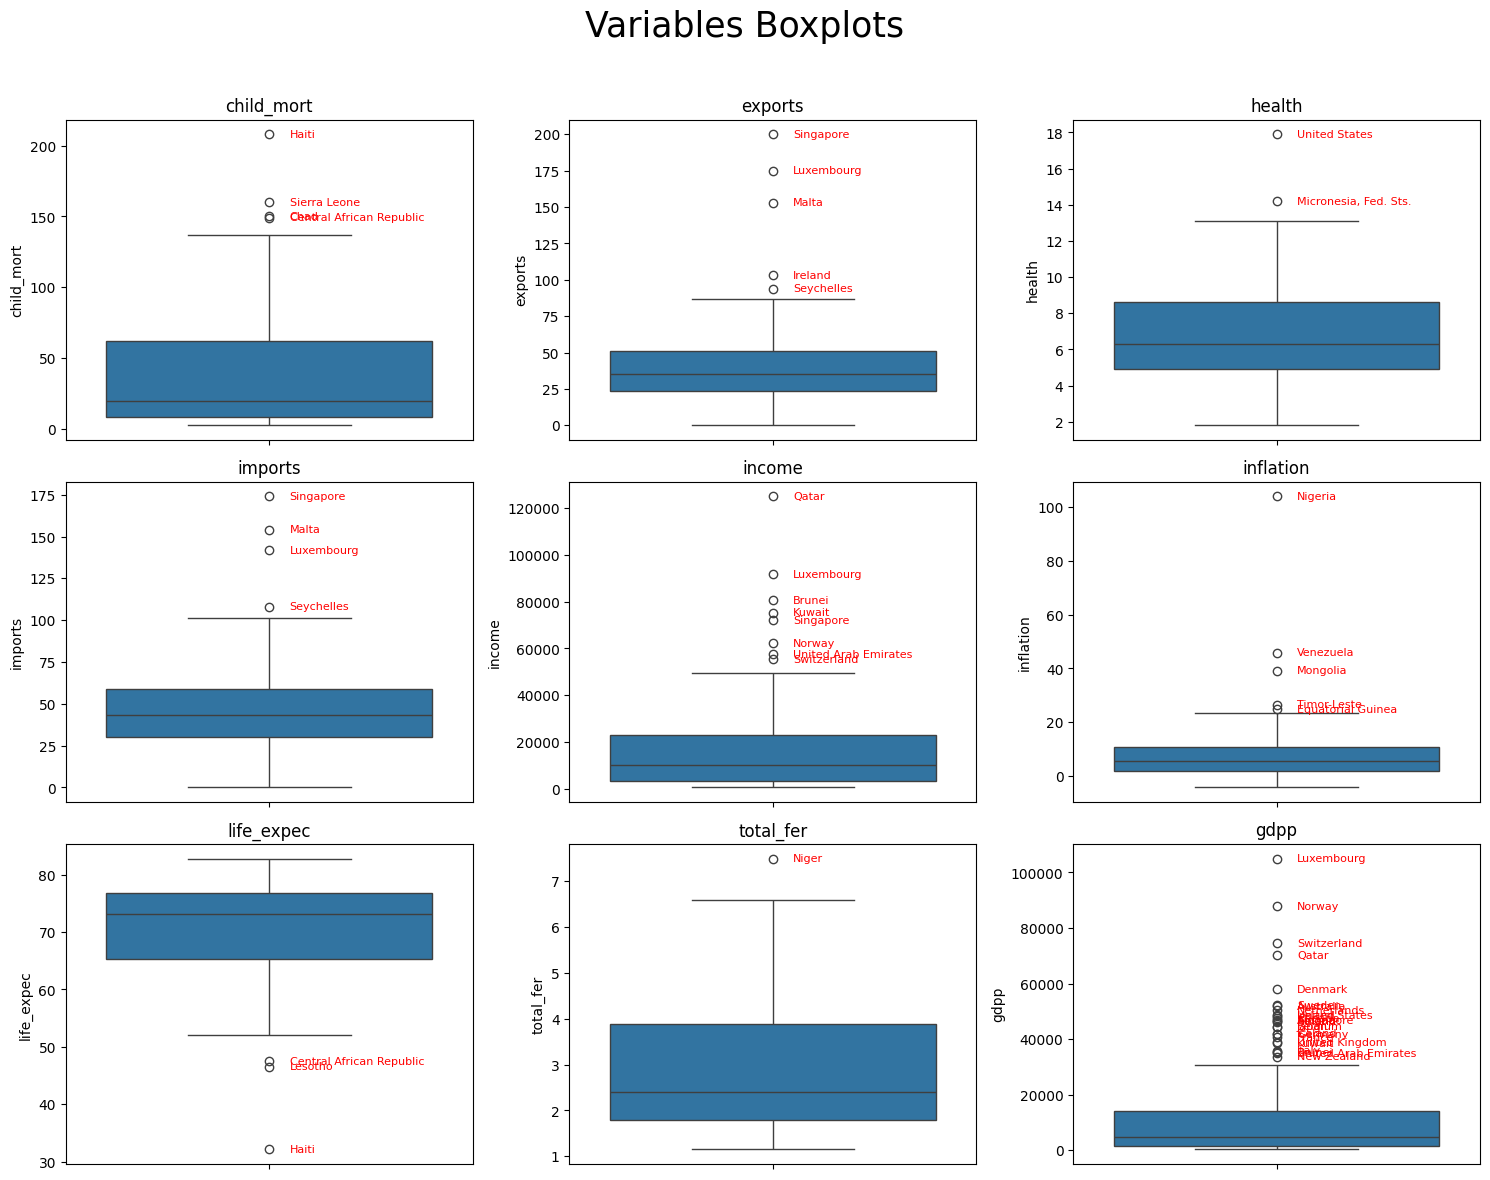

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  
axes = axes.flatten()  

for i, var in enumerate(num_var):
    ax = axes[i]
    sns.boxplot(df[var], ax=axes[i])
    ax.set_title(var)

    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]

    for j in range(len(outliers)):
        y = outliers.iloc[j][var]
        label = outliers.iloc[j]['country']
        ax.text(x=0.05, y=y, s=label, fontsize=8, color='red', ha='left', va='center')
    
plt.suptitle("Variables Boxplots", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In general, the presence of long tails can be observed in almost all the distributions of the variables, particularly for the economic variables such as `income`, `inflation`, `gdpp`, and to a lesser extent `export`. This is likely due to the inclusion of a wide range of countries that differ in terms of population and, most importantly, level of economic development. Indeed, at first glance, among the upper outliers in `income`, countries such as Qatar, Luxembourg, the USA, and others with a high concentration of capital can be noted; the same applies to `gdpp` and `import`.

Furthermore, by examining the summary statistics of the variables, it becomes evident that the standard deviations of the distributions vary greatly in scale. Therefore, for a multivariate analysis, it is useful to standardize all the variables to bring them onto the same scale and avoid distorting the analysis.


## Multivariate analysis

In [8]:
df_std = df.copy()
df_std[num_var] = StandardScaler().fit_transform(X=df_std[num_var])

In [9]:
mean_vec = np.mean(df_std[num_var], axis=0)
cov_inv = np.linalg.inv(np.cov(df_std[num_var], rowvar=False))

mahlanobis = np.array([
    distance.mahalanobis(row, mean_vec, cov_inv)
    for _, row in df_std[num_var].iterrows()
])

df_std['mahal_dist'] = mahlanobis

trh = np.sqrt(chi2.ppf(.95, df=len(num_var)))
df_out = df_std[df_std["mahal_dist"] > trh]
df_no_out = df_std[df_std["mahal_dist"] <= trh]

outliers_dict = {}

for var in num_var:
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    outliers_dict[var] = [i for i in outliers.index]



In [10]:
df_out_graphic = df_out.style.apply(
    lambda row: [
        'background-color: salmon; font-weight: bold'
        if (col in num_var and row.name in outliers_dict.get(col, [])) else ''
        for col in row.index
    ],
    axis=1
)

df_out_graphic


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,mahal_dist
23,Brunei,-0.690660,0.961991,-1.451722,-0.782625,3.301480,0.846206,0.738094,-0.734087,1.222291,5.379794
66,Haiti,4.221297,-0.944352,0.034438,0.737863,-0.813969,-0.221257,-4.337186,0.253120,-0.673215,8.077035
82,Kuwait,-0.683199,0.936378,-1.528404,-0.683193,3.020526,0.324335,0.862156,-0.488942,1.397406,4.500052
87,Lesotho,1.527804,-0.062532,1.564416,2.241778,-0.768184,-0.344609,-2.713097,0.233243,-0.645415,5.068359
88,Liberia,1.269149,-0.805310,1.820021,1.893764,-0.855591,-0.219360,-1.100286,1.372838,-0.691547,4.438200
91,Luxembourg,-0.882164,4.899083,0.348467,3.940415,3.878996,-0.394898,1.211786,-0.873224,5.036507,7.107627
98,Malta,-0.782681,4.094101,0.669799,4.437577,0.580393,-0.374972,1.099002,-1.052114,0.445220,5.105194
113,Nigeria,2.281385,-0.578452,-0.637438,-1.221785,-0.624065,9.129718,-1.134121,1.916133,-0.581936,9.618096
114,Norway,-0.872216,-0.051555,0.972873,-0.761910,2.349360,-0.173815,1.177951,-0.661206,4.095266,5.745444
123,Qatar,-0.727966,0.775381,-1.827827,-0.956632,5.611542,-0.076082,1.008775,-0.581700,3.137608,8.258332


The multivariate outliers, identified using Mahalanobis distance, correspond to countries that also show anomalous values in some univariate variables, particularly within thematically homogeneous groups such as those related to the economy or health. This suggests that such anomalies do not result from data errors, but rather reflect specific structural conditions of these countries. For this reason, these observations were not removed, as they represent interesting and informative cases for the analysis, rather than statistical noise.


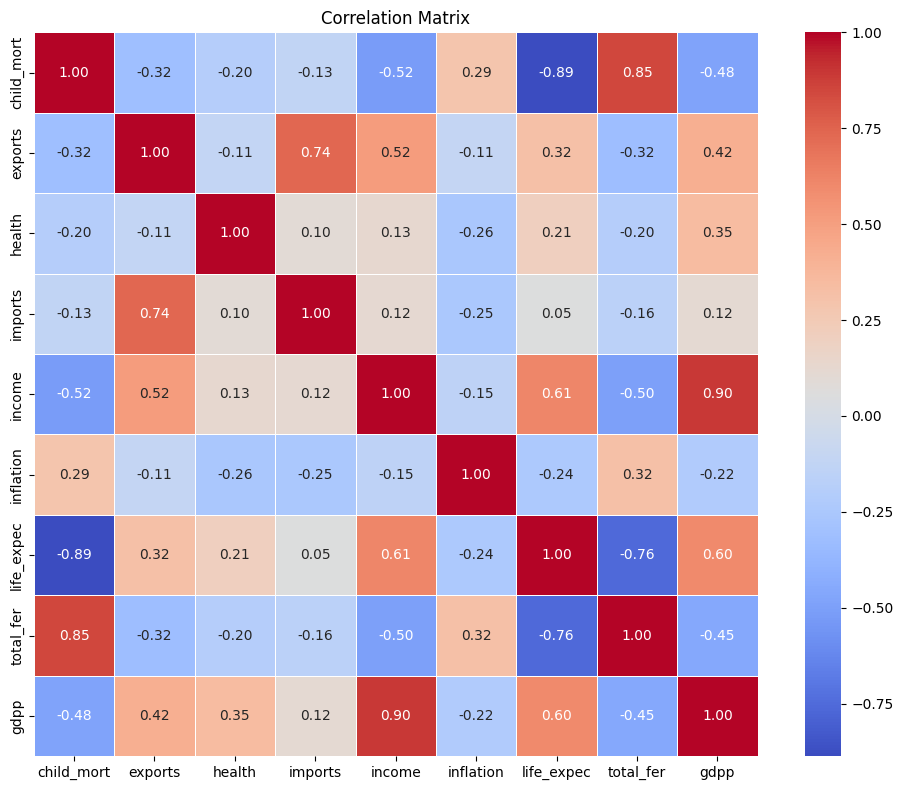

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [12]:
R = df_std[num_var].corr()
rv = np.linalg.det(R)

The relative variability index is very low, indicating a high correlation among the variables (observable also from the correlation matrix). Therefore, it makes sense to proceed with a dimensionality reduction.


### Factorial Analysis

In [13]:
kmo_all, kmo_model = calculate_kmo(df_std[num_var])

print(f"KMO globale: {kmo_model:.3f}")

KMO globale: 0.678


The KMO is in the range of 0.61-0.70, which is generally considered "modest", so common factors are likely.

In [14]:
eigenvalues, eigenvectors = np.linalg.eig(R)
print(eigenvalues[eigenvalues > 1])
print(sum(eigenvalues[0:3])/len(num_var))

[4.13565658 1.54634631 1.1703833 ]
0.7613762433466722


The first three factors satisfy the Kaiser criterion and explain 76% of the total variance in the sample. Therefore, three factors are extracted.

In [16]:
trasformer = FactorAnalysis(n_components = 3, rotation="varimax", )
fa = trasformer.fit_transform(df_std[num_var])
factor = pd.DataFrame(trasformer.components_.T, index=df_std[num_var].columns, columns = ["Trade_Econ", "Demographics", "Wealth"])
factor["Communalities"] =  factor.apply(lambda row: (row**2).sum(), axis=1)
factor["Uniquenesses"] = 1 - factor["Communalities"]
factor

,Trade_Econ,Demographics,Wealth,Communalities,Uniquenesses
child_mort,-0.105477,0.965307,-0.211153,0.987529,0.012471
exports,0.943115,-0.167460,0.269878,0.990344,0.009656
health,-0.239909,-0.159719,0.331876,0.193208,0.806792
imports,0.772212,-0.046400,-0.001713,0.598467,0.401533
income,0.252829,-0.336889,0.817640,0.845953,0.154047
inflation,-0.029338,0.264102,-0.143273,0.091138,0.908862
life_expec,0.078790,-0.826103,0.381192,0.833962,0.166038
total_fer,-0.130933,0.815508,-0.223839,0.732301,0.267699
gdpp,0.125098,-0.281032,0.940295,0.978783,0.021217


The three factors, as already suggested by the names given to the columns, represent:

1. **Economic factor related to trade and production**: high loadings on `exports`, `imports`, and `income` indicate commercial and economic activity.
2. **Demographic health factor**: strong correlation with `child_mort`, `total_fer`, and a negative loading on `life_expec` suggest demographic and health-related aspects.
3. **Wealth and healthcare well-being factor**: high loadings on `gdpp`, `income`, and `health` indicate wealth and well-being conditions.

In general, the variables are well explained by the factors (*Communalities > 0.7*), except for `health` and `gdpp`.


In [17]:
df_fact = pd.DataFrame(trasformer.transform(df_std[num_var]), columns=["Trade_Econ", "Demographics", "Wealth"], index=df['country'])

In [18]:
df_fact

,Trade_Econ,Demographics,Wealth
country,,,
Afghanistan,-0.893402,1.223542,-0.259271
Albania,-0.442406,-0.773170,-0.662630
Algeria,-0.027209,-0.426244,-0.574543
Angola,1.184958,2.155482,-0.059744
Antigua and Barbuda,0.121290,-0.765334,-0.274846
...,...,...,...
Vanuatu,0.372715,-0.281139,-0.757581
Venezuela,-0.580723,-0.606700,-0.080297
Vietnam,1.384925,-0.463582,-0.995730


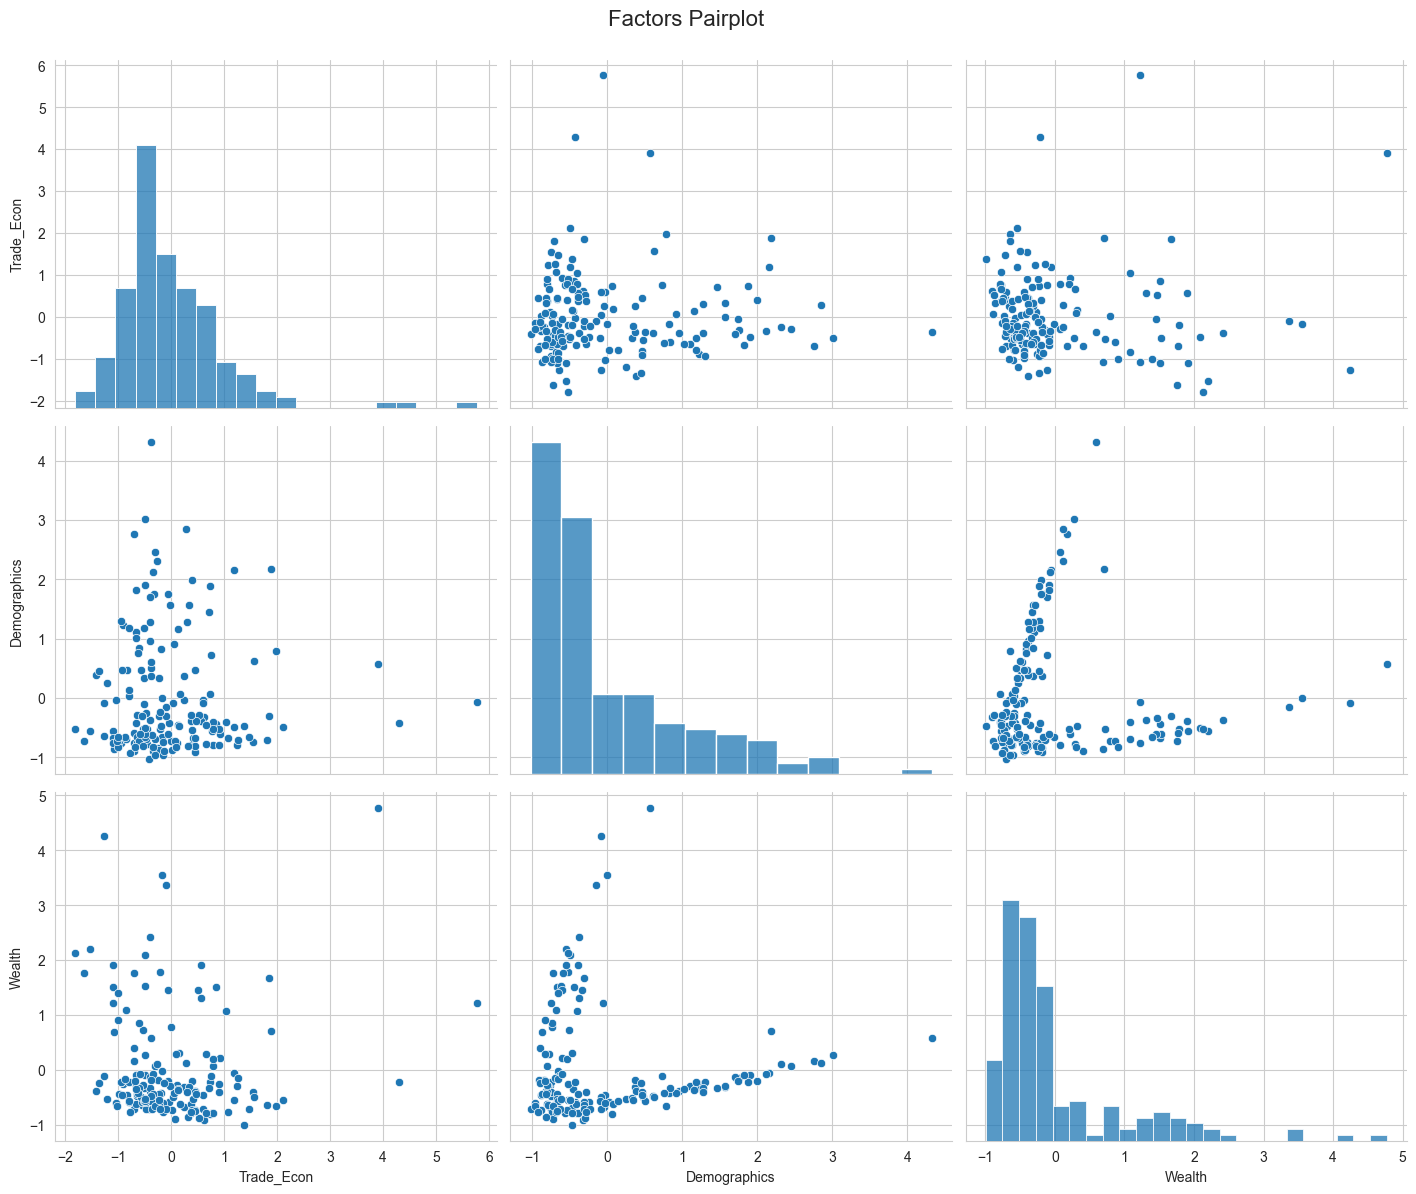

In [19]:
sns.set_style("whitegrid")
plot = sns.pairplot(df_fact)
plot.fig.set_size_inches(15,12)
plot.fig.suptitle("Factors Pairplot", fontsize =16, y=1.02)
plt.show()

### PCA

In [20]:
cum_ev = np.cumsum(eigenvalues/(sum(eigenvalues)))
print(cum_ev)

[0.4595174  0.63133365 0.76137624 0.87190786 0.94530998 0.97015232
 0.97758288 0.9873957  1.        ]


The first four components explain 87% of the total variance in the data. Therefore, the dimension can be reduced to four variables.

In [21]:
pca_transformer = PCA(n_components=4)
pca = pca_transformer.fit_transform(df_std[num_var])
pca_components = pd.DataFrame(pca_transformer.components_.T, index=num_var)
pca_components.columns = ["SocialEconomic_Status", "Globalization", "2", "3"]
pca_components.style.background_gradient(cmap='coolwarm', axis=0)


,SocialEconomic_Status,Globalization,2,3
child_mort,-0.419519,0.192884,-0.029544,0.370653
exports,0.283897,0.613163,0.144761,0.003091
health,0.150838,-0.243087,-0.596632,0.461897
imports,0.161482,0.671821,-0.299927,-0.071907
income,0.398441,0.022536,0.301548,0.392159
inflation,-0.193173,-0.008404,0.642520,0.150442
life_expec,0.425839,-0.222707,0.113919,-0.203797
total_fer,-0.403729,0.155233,0.019549,0.378304
gdpp,0.392645,-0.046022,0.122977,0.531995


In [22]:
pca_transformer.explained_variance_ratio_

array([0.4595174 , 0.17181626, 0.13004259, 0.11053162])

In [23]:
df_pca = pd.DataFrame(pca_transformer.transform(df_std[num_var]), index=df['country'])
df_pca.columns = ["SocialEconomic_Status", "Globalization", "2", "3"]

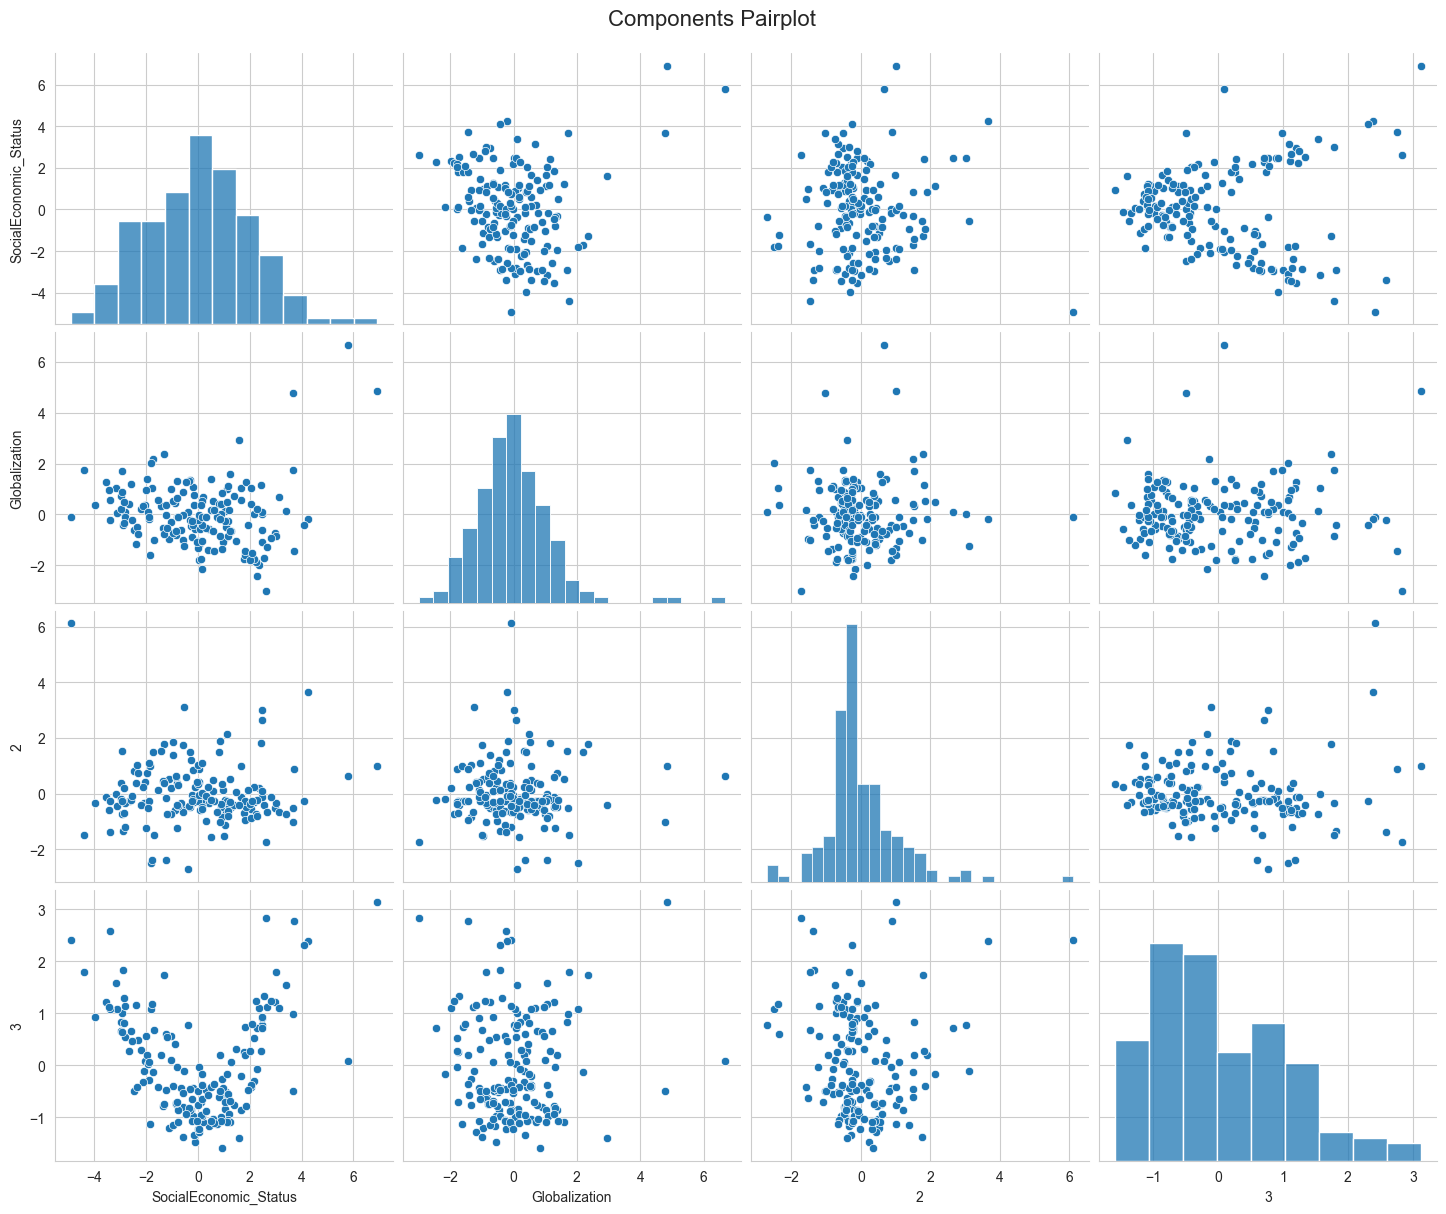

In [24]:
sns.set_style("whitegrid")
plot = sns.pairplot(df_pca)
plot.fig.set_size_inches(15,12)
plot.fig.suptitle("Components Pairplot", fontsize =16, y=1.02)
plt.show()

## Cluster analysis

### Hierachical cluster

In [44]:
def hc_best(dist_matrix, max_k=10, methods=["complete", "average", "single"]):
    results = {}

    for method in methods:

        Z = linkage(dist_matrix, method=method)
        asw_all = []
        groups_list = []

        for k in range(2, max_k + 1):
            labels = fcluster(Z, k, criterion='maxclust')
            asw = silhouette_score(dist_matrix, labels, metric='precomputed')
            asw_all.append(asw)
            groups_list.append(labels)

        k_best = np.argmax(asw_all) + 2
        best_groups = groups_list[k_best - 2]

        results[method] = {
            "asw": asw_all[k_best - 2],
            "k_best": k_best
        }

    best_method = max(results, key=lambda m: results[m]["asw"])
    print(f"\nThe best method is: {best_method} with ASW = {results[best_method]['asw']:.4f}, using {k_best} clusters")


    result = results[best_method]
    result["method"] = best_method
    return result


Clusterizzazione dei fattori


In [45]:
dist_matrix_fact = squareform(pdist(df_fact, metric="euclidean"))
hc_best(dist_matrix_fact,len(df_fact))


The best method is: single with ASW = 0.6581, using 2 clusters


{'asw': 0.6581036714955739, 'k_best': 2, 'method': 'single'}

In [27]:
Z = linkage(dist_matrix_fact, method="average")
clust = fcluster(Z, t=2, criterion='maxclust')
df_fact["clust"] = clust

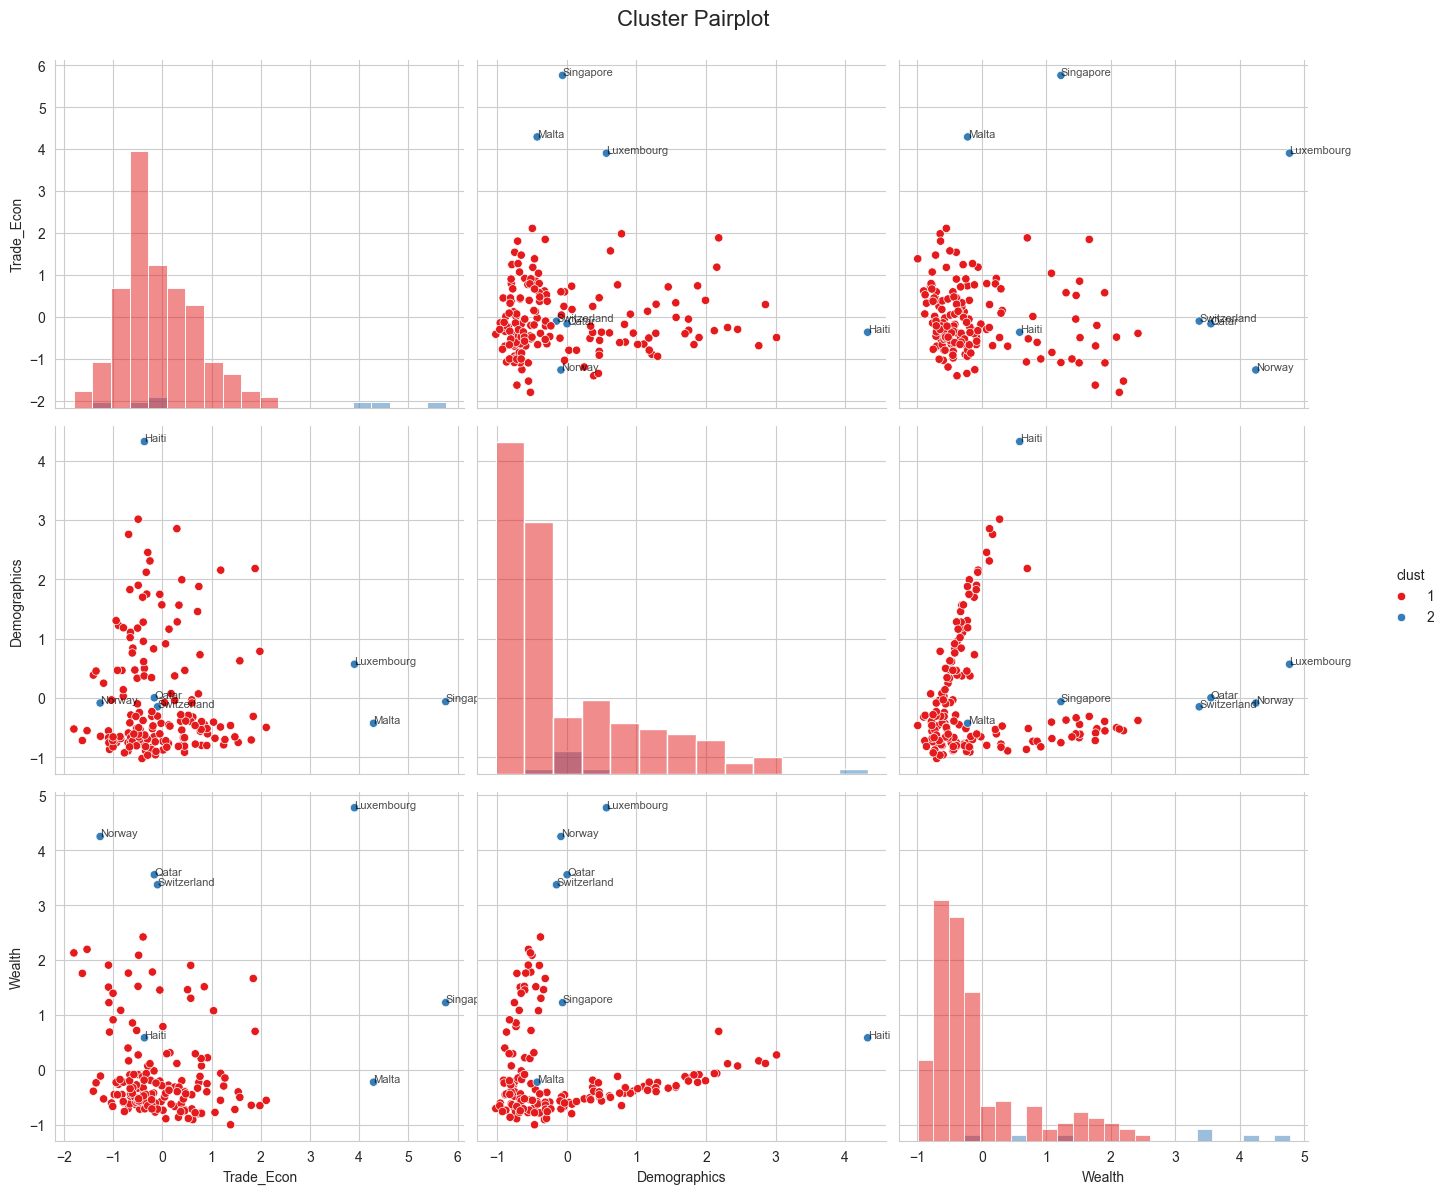

In [28]:
pair = sns.pairplot(df_fact, hue='clust', palette="Set1", diag_kind='hist')
pair.fig.set_size_inches(15, 12)
pair.fig.suptitle("Cluster Pairplot", fontsize=16, y=1.02)

df_group1 = df_fact[df_fact['clust'] == 2]


for i, row_var in enumerate(pair.x_vars):
    for j, col_var in enumerate(pair.y_vars):
        if i != j:
            ax = pair.axes[j, i]  
            for idx, point in df_group1.iterrows():
                ax.text(point[row_var], point[col_var], str(idx),
                        fontsize=8, color='black', alpha=0.7)


plt.show()


PCA Cluster 

In [29]:
dist_matrix = squareform(pdist(df_pca, metric="euclidean"))
hc_best(dist_matrix,len(df_fact))


The best method is: average with ASW = 0.6203, using 2 clusters


{'asw': 0.6203450536137912,
 'asw_all': [0.6203450536137912,
  0.4241963368219658,
  0.42138284154389927,
  0.30070844917004713,
  0.2873040271506993,
  0.28087802797447303,
  0.2505859348087587,
  0.20416310868540644,
  0.1926497740915658,
  0.19231885137396543,
  0.19300990902023887,
  0.20255572046241963,
  0.19597394544471647,
  0.2101191406849651,
  0.21902153814305336,
  0.22922997603169407,
  0.22238606460439236,
  0.208935502156185,
  0.20681870911837644,
  0.1395912981513002,
  0.15097517129503102,
  0.15422252504499623,
  0.14630526069649602,
  0.137020230360012,
  0.16028212766256586,
  0.16137996450732123,
  0.15704530834411712,
  0.15284200096346892,
  0.1571769814691975,
  0.17307255294312515,
  0.16640866993828296,
  0.16076387972860923,
  0.15956879308168315,
  0.1589715080102359,
  0.15770448709920473,
  0.1566333047704748,
  0.15706762144658643,
  0.16374964526528848,
  0.16210746585542246,
  0.16270485022890974,
  0.17198758427448665,
  0.17388393045857528,
  0.17370

In [30]:
Z = linkage(dist_matrix, method="average")
clust = fcluster(Z, t=2, criterion='maxclust')
df_pca["clust"] = clust

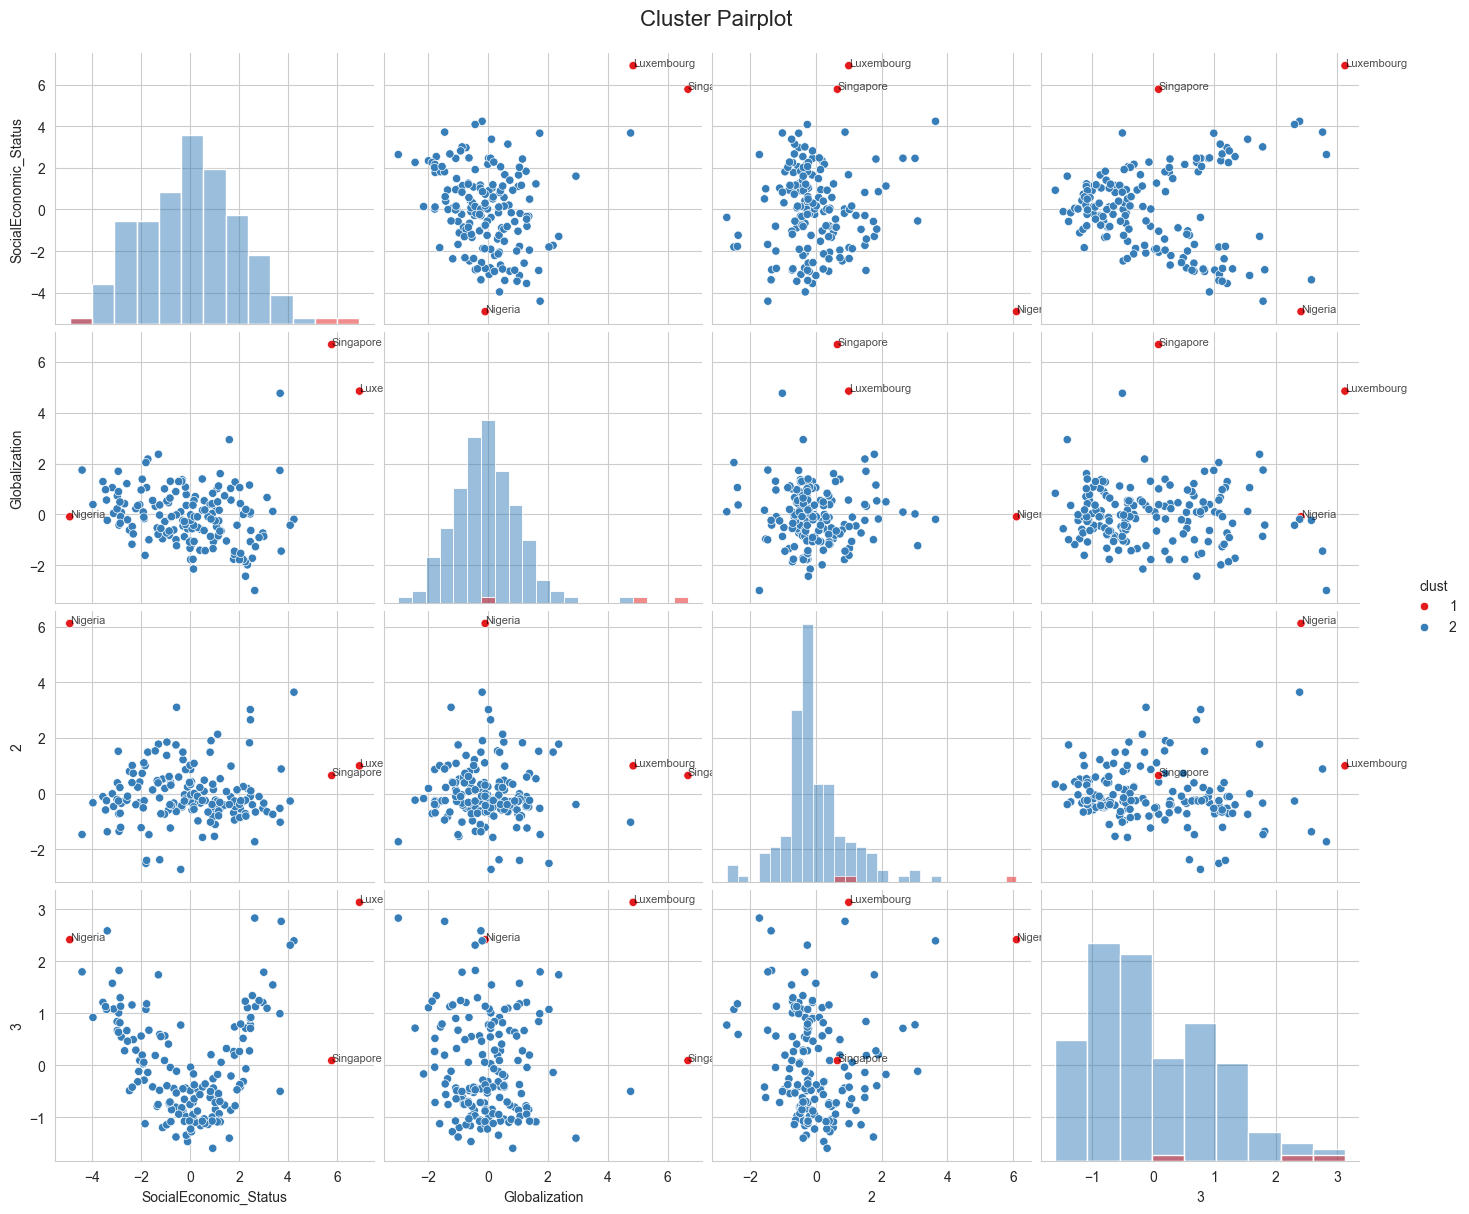

In [31]:
pair = sns.pairplot(df_pca, hue='clust', palette="Set1", diag_kind='hist')
pair.fig.set_size_inches(15, 12)
pair.fig.suptitle("Cluster Pairplot", fontsize=16, y=1.02)

df_group1 = df_pca[df_pca['clust'] == 1]

for i, row_var in enumerate(pair.x_vars):
    for j, col_var in enumerate(pair.y_vars):
        if i != j:
            ax = pair.axes[j, i]  
            for idx, point in df_group1.iterrows():
                ax.text(point[row_var], point[col_var], str(idx),
                        fontsize=8, color='black', alpha=0.7)


plt.show()


Hierarchical cluster analysis does not reveal any particular insight into possible clustering.

### K-Means

In [32]:
def k_best(dataset, max_cluster=10):
    results = []

    for n_clusters in range(2, max_cluster + 1):

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(dataset)

        silhouette_avg = silhouette_score(dataset, cluster_labels)

        print(f"n_clusters = {n_clusters} --> silhouette score = {silhouette_avg:.4f}")

        results.append((n_clusters, silhouette_avg))
    
    return results


In [33]:
k_best(df_pca)

n_clusters = 2 --> silhouette score = 0.3368
n_clusters = 3 --> silhouette score = 0.3342
n_clusters = 4 --> silhouette score = 0.2549
n_clusters = 5 --> silhouette score = 0.2383
n_clusters = 6 --> silhouette score = 0.2717
n_clusters = 7 --> silhouette score = 0.2939
n_clusters = 8 --> silhouette score = 0.2791
n_clusters = 9 --> silhouette score = 0.2571
n_clusters = 10 --> silhouette score = 0.2573


[(2, 0.33678874620549376),
 (3, 0.33421393466285093),
 (4, 0.2548893352673684),
 (5, 0.23825123849554763),
 (6, 0.2716963234349915),
 (7, 0.2939191163822583),
 (8, 0.27906057771320264),
 (9, 0.2570518728515881),
 (10, 0.25725635502132543)]

Factor K_means 

In [34]:
clusterer = KMeans(n_clusters=2,random_state=0)
cluster_labels = clusterer.fit_predict(df_fact)
df_fact['k_means'] = cluster_labels

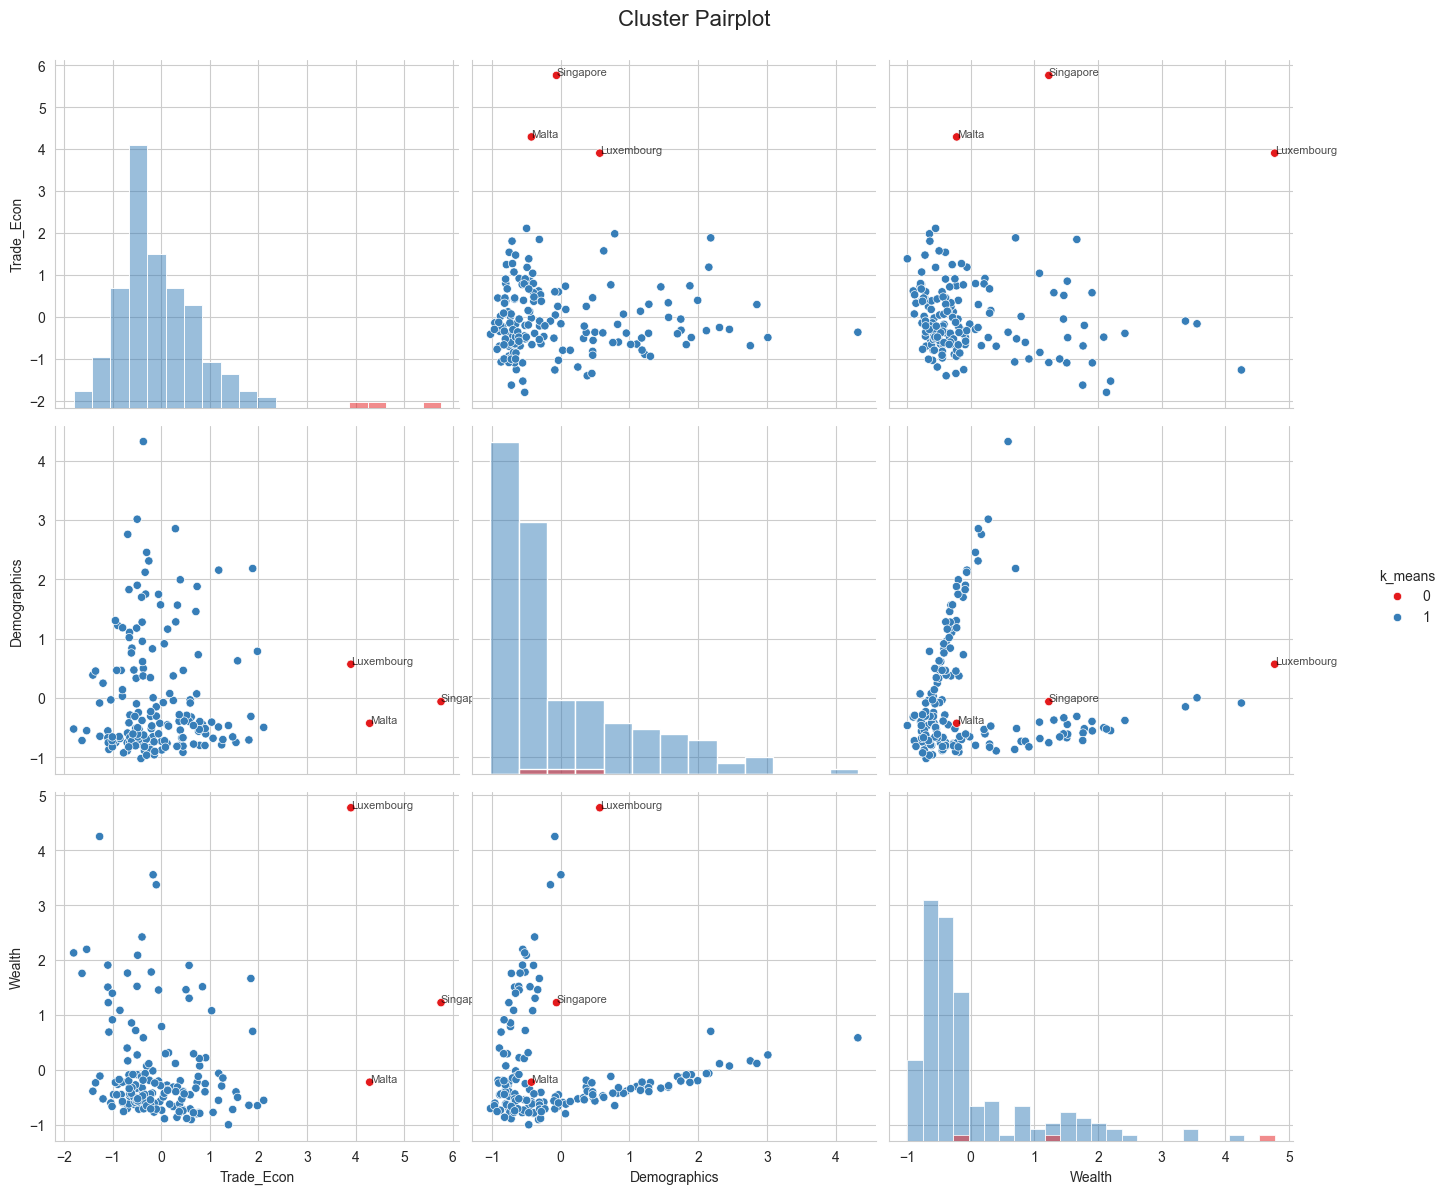

In [35]:
pair = sns.pairplot(df_fact.drop("clust", axis=1), hue='k_means', palette="Set1", diag_kind='hist')
pair.fig.set_size_inches(15, 12)
pair.fig.suptitle("Cluster Pairplot", fontsize=16, y=1.02)

df_group1 = df_fact[df_fact['k_means'] == 0]

for i, row_var in enumerate(pair.x_vars):
    for j, col_var in enumerate(pair.y_vars):
        if i != j:
            ax = pair.axes[j, i]  
            for idx, point in df_group1.iterrows():
                ax.text(point[row_var], point[col_var], str(idx),
                        fontsize=8, color='black', alpha=0.7)

plt.show()


K-Means pca

In [36]:
clusterer = KMeans(n_clusters=2,random_state=0)
cluster_labels = clusterer.fit_predict(df_pca)
df_pca['k_means'] = cluster_labels
df_pca['k_means']= df_pca['k_means'].replace({0 : "High SE_Status", 1 : "Low SE_Status"})

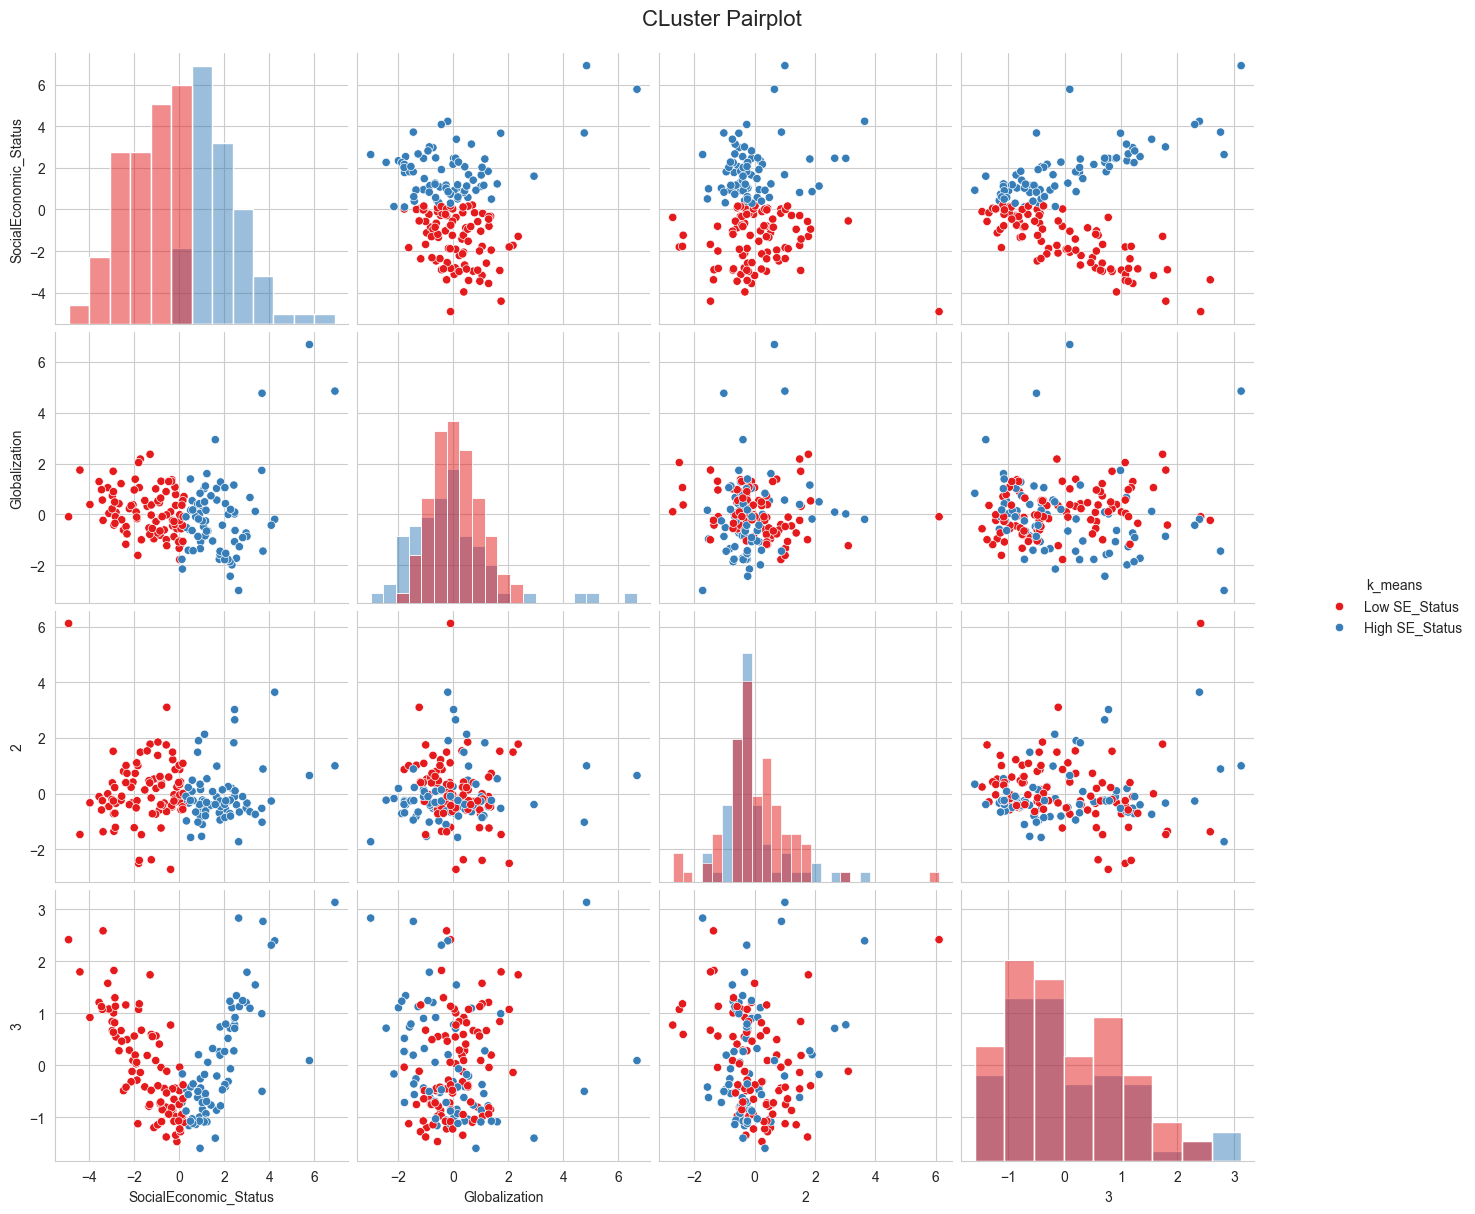

In [37]:
pair = sns.pairplot(df_pca.drop("clust", axis=1), hue='k_means', palette="Set1", diag_kind='hist')
pair.fig.set_size_inches(15, 12)
pair.fig.suptitle("CLuster Pairplot", fontsize=16, y=1.02)
plt.show()


The clustering of the components reveals the distinction of two distinct groups with regard to the socio-economic status of the nations

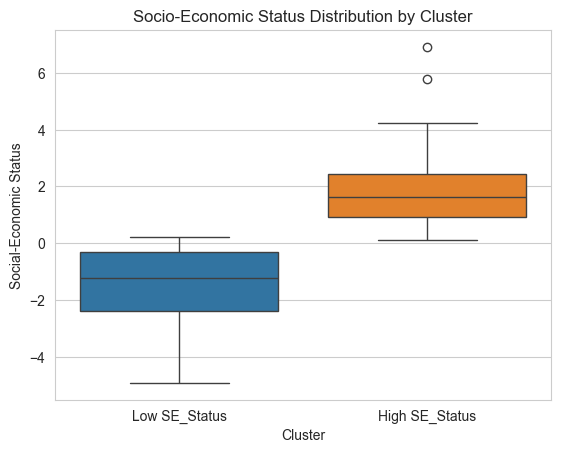

In [38]:
sns.boxplot(df_pca, y="SocialEconomic_Status", x="k_means", hue="k_means")
plt.ylabel("Social-Economic Status")  
plt.xlabel("Cluster")                
plt.title("Socio-Economic Status Distribution by Cluster") 
plt.show()

In [41]:
scaler = MinMaxScaler()
df_final = df_pca[df_pca['k_means'] == "Low SE_Status"].sort_values(by="SocialEconomic_Status")[["SocialEconomic_Status"]]
df_final['score_MinMax'] = scaler.fit_transform(df_final[["SocialEconomic_Status"]]*(-1))
df_final["perc"] = df_final['score_MinMax']/sum(df_final['score_MinMax'])*100
df_final[['perc']].head(10)

,perc
country,
Nigeria,3.335627
Haiti,3.008564
Central African Republic,2.719000
Chad,2.453749
Niger,2.383833
Mali,2.359149
Sierra Leone,2.339207
"Congo, Dem. Rep.",2.203619
Burkina Faso,2.170208


# Conclusions
The exploratory analyses conducted allow for the identification of a potential criterion to determine which countries are most in need of the allocated funds.  
In particular, through principal component analysis, the presence of a socioeconomic development/status variable for each country was identified, which alone captures 80% of the total data variability. This made it possible to identify two distinct groups:

- High socioeconomic development;
- Low socioeconomic development.

To allocate NGO funds, the recommendation is to focus on the 93 countries that fall within the lower socioeconomic development group, and distribute the funds in proportion to the scores assigned by normalizing the socioeconomic development variable.
